In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import numpy as np
import gym
from tqdm import tqdm

import matplotlib.pyplot as plt

/home/prerak-contractor/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [3]:
EPSILON = 0.5
LEARNING_RATE = 1e-4
EPISODES = 2500
K = 35
E = 2048
GAMMA = 0.9
INTERVAL = 500

In [4]:
class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc = F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x).to(device)
            x = x.unsqueeze(0)
        
        x = self.activation_fc(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation_fc(layer(x))
        x = self.output_layer(x)
        return x
        

In [9]:
env = gym.make('CartPole-v1')
state, _ = env.reset()
fcq = FCQ(4, 2, (512, 128)).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(fcq.parameters(), lr=LEARNING_RATE)

states = []
actions = []
rewards = [] 
next_states = []
is_terminals = []


Discrete(2)


  5%|▍         | 124/2500 [00:00<00:05, 418.23it/s]/tmp/ipykernel_6440/2773329543.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  x = torch.FloatTensor(x).to(device)
 18%|█▊        | 462/2500 [00:02<00:08, 232.44it/s]

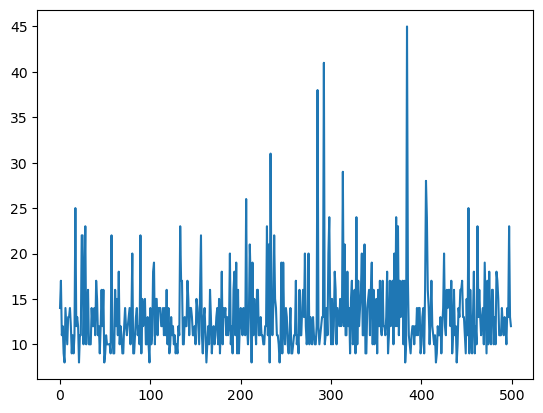

 39%|███▉      | 974/2500 [00:06<00:10, 140.58it/s]

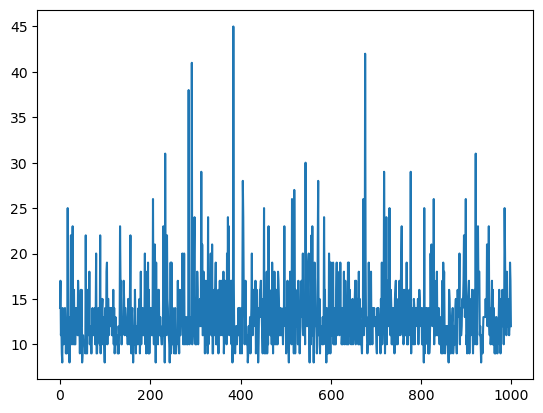

 60%|█████▉    | 1493/2500 [00:17<00:27, 36.41it/s] 

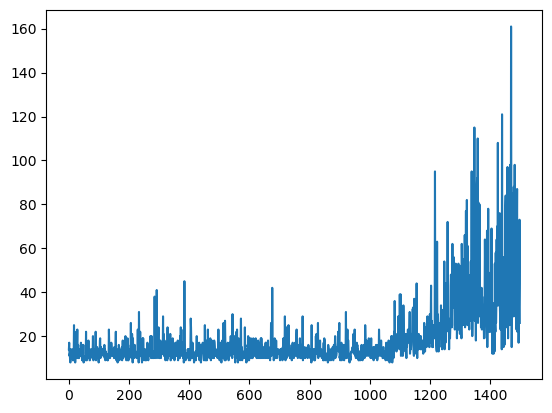

 80%|███████▉  | 1996/2500 [00:57<00:22, 22.62it/s]

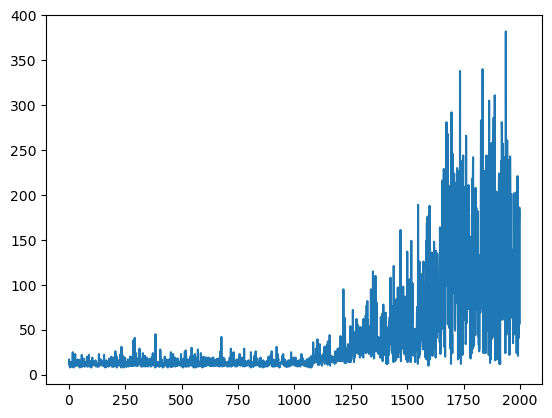

100%|█████████▉| 2498/2500 [01:48<00:00, 11.94it/s]

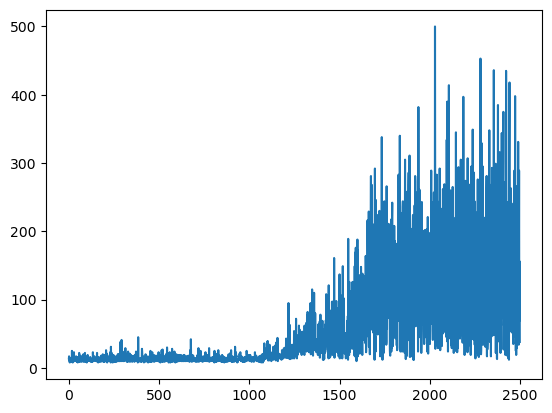

100%|██████████| 2500/2500 [01:48<00:00, 22.94it/s]


In [6]:
total_validate_rewards = []
for episode in tqdm(range(EPISODES)):
    
    validate_rewards = []
    done = False
    state, _ = env.reset()
    while not done: 
        with torch.no_grad():
            action_values = fcq(state)
        if np.random.random() <= EPSILON:
            action = env.action_space.sample()
        else:
            action = int(torch.argmax(action_values.squeeze()))
        next_state, reward, terminated, truncated , info = env.step(action)
        
        done = terminated or truncated
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        is_terminals.append(terminated and not truncated)
        validate_rewards.append(reward)
            
        state = next_state
        
        if(len(states) >= E):
            for _ in range(K):
                action_values = fcq(states).squeeze()
                idxs = torch.tensor(actions).long().unsqueeze(1)
                action_values = action_values.gather(1, idxs)
                
                
                with torch.no_grad():
                    next_action_values = fcq(next_states).detach().squeeze()
                    next_action_values, _ = next_action_values.max(dim=1)
                
                target = np.array(rewards) + GAMMA*np.array(next_action_values)*(1-np.array(is_terminals))
                target = torch.from_numpy(target).unsqueeze(1).float()
                
                loss = loss_fn(action_values, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            states = []
            actions = []
            rewards = [] 
            next_states = []
            is_terminals = []
    total_validate_rewards.append(np.sum(validate_rewards))
    
    if((episode + 1) % INTERVAL) == 0:
        plt.plot(range(len(total_validate_rewards)), total_validate_rewards)
        plt.show()  
torch.save(fcq, "model.pth")        

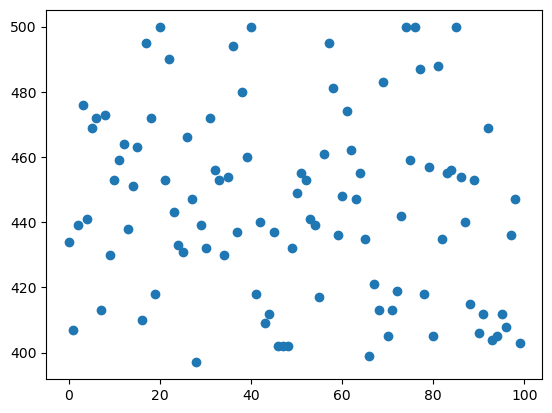

In [10]:
env = gym.make('CartPole-v1', render_mode="human")
with torch.no_grad():
    eval_fcq = torch.load("model.pth")
    EVAL_EPISODES = 5
    eval_rewards_total = []
    for episode in range(EVAL_EPISODES):
        state, _ = env.reset()
        eval_rewards = []
        done = False
        while not done:
            action_values = eval_fcq(state)
            action = int(torch.argmax(action_values.squeeze()))
            next_state, reward, terminated, truncated , info = env.step(action)
            env.render()
            done = terminated or truncated
            
            eval_rewards.append(reward)
            state = next_state

        eval_rewards_total.append(np.sum(eval_rewards))

plt.scatter(range(len(eval_rewards_total)), eval_rewards_total)
plt.show()         
            